Saved: ../outputs_duffing\Duffing_fd_noise0.000.npz
[Duffing clean] Run finished in 110.56 seconds
Saved results to: ../outputs_duffing\Duffing_fd_noise0.000.npz
Duffing (fd, noise=0.000)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 0.999975*v
dv/dt = -1.00012*x - 0.0999972*v - 4.99912*x^3 + 0.369991*cos(1t)


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\brads\AppData\Local\Temp\ipykernel_16308\54535313.py:88: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_clean.show()


Saved: ../outputs_duffing\Duffing_fd_noise0.010.npz
[Duffing 1% noise] Run finished in 109.08 seconds
Saved results to: ../outputs_duffing\Duffing_fd_noise0.010.npz
Duffing (fd, noise=0.010)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 1.00019*v
dv/dt = -1.00385*x - 0.0996406*v - 4.9758*x^3 + 0.369987*cos(1t)


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\brads\AppData\Local\Temp\ipykernel_16308\54535313.py:120: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_noise.show()


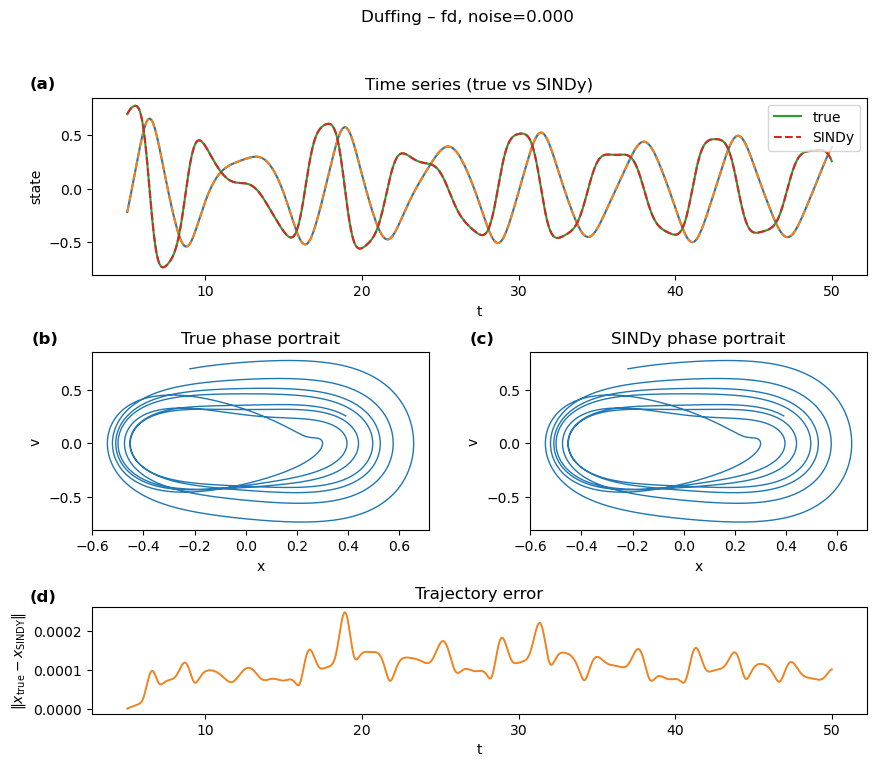

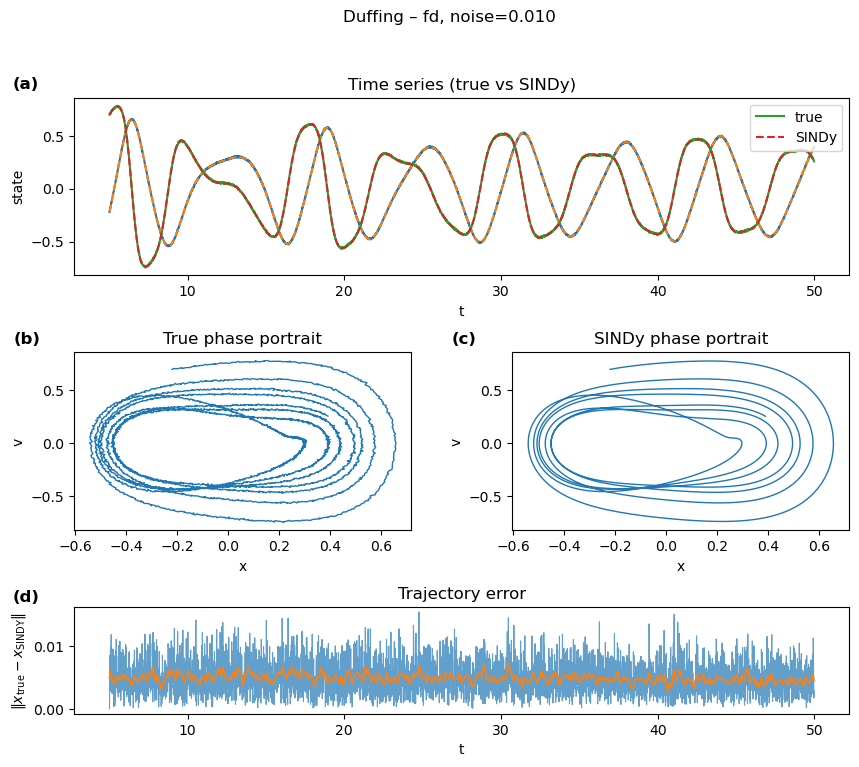

In [ ]:
import sys, os, time

sys.path.append(os.path.join("..", "src"))

import jax.numpy as jnp
from systems import DuffingDefinition
from sindy_core import SINDyConfig
from run_model import (
    run_sindy_experiment,
    load_experiment,
    make_composite_figure,
    print_equations_from_result,
)

# -------------------------------------------------------
# 1. Duffing parameters
# -------------------------------------------------------
params = dict(
    alpha=1.0,  # linear stiffness
    beta=5.0,  # cubic stiffness
    gamma=0.37,  # forcing amplitude
    delta=0.1,  # damping
    omega=1.0,  # forcing frequency
)

duffing = DuffingDefinition(
    parameters=params,
    x0_vector=jnp.array([0.0, 0.0]),  # initial x, v
    t0=0.0,
    tf=50.0,  # long enough to see steady-state response
    dt=0.01,
)

# -------------------------------------------------------
# 2. SINDy config: polynomial + Fourier, project defaults
# -------------------------------------------------------
cfg_duffing = SINDyConfig(
    poly_degree=3,
    include_bias=True,
    threshold=0.05,  
    n_iter=10,
    post_tol=1e-3,
    var_names=("x", "v"),
    mode="polynomial_and_fourier",
    k_max=3,
    include_sin=True,
    include_cos=True,
    fourier_prefix="t",
    normalize=True,  
    stlsq_mode="pruned",
)


outdir = "../outputs_duffing"

# =======================================================
# A. Clean run: FD derivatives, no noise
# =======================================================
t0_run = time.perf_counter()
path_clean = run_sindy_experiment(
    problem=duffing,
    deriv_key="fd",  # finite-difference derivative
    noise_level=0.0,  # clean data
    sindy_config=cfg_duffing,
    outdir=outdir,
    drop_transient=5.0,  # discard early transient
)
elapsed_clean = time.perf_counter() - t0_run
print(f"[Duffing clean] Run finished in {elapsed_clean:.2f} seconds")
print("Saved results to:", path_clean)

result_clean = load_experiment(path_clean)
print_equations_from_result(result_clean)

fig_clean, axes_clean = make_composite_figure(
    result_clean,
    phase_i=0,
    phase_j=1,  # x–v phase plane
    labels=["x", "v"],
)
os.makedirs("../figs", exist_ok=True)
fig_clean.savefig(
    "../figs/duffing_fd_clean_composite.png",
    dpi=300,
    bbox_inches="tight",
)
fig_clean.show()

# =======================================================
# B. Noisy run: FD derivatives, 1% relative noise (optional)
# =======================================================
t0_run = time.perf_counter()
path_noise = run_sindy_experiment(
    problem=duffing,
    deriv_key="fd",
    noise_level=0.01,  # 1% relative noise
    sindy_config=cfg_duffing,
    outdir=outdir,
    drop_transient=5.0,
)
elapsed_noise = time.perf_counter() - t0_run
print(f"[Duffing 1% noise] Run finished in {elapsed_noise:.2f} seconds")
print("Saved results to:", path_noise)

result_noise = load_experiment(path_noise)
print_equations_from_result(result_noise)

fig_noise, axes_noise = make_composite_figure(
    result_noise,
    phase_i=0,
    phase_j=1,
    labels=["x", "v"],
)
fig_noise.savefig(
    "../figs/duffing_fd_noise001_composite.png",
    dpi=300,
    bbox_inches="tight",
)
fig_noise.show()

In [ ]:
import numpy as np
import pandas as pd


def build_duffing_coeff_table(result, params):
    feature_names = [str(s) for s in result["feature_names"]]
    Xi = np.asarray(result["Xi"])  # shape (n_features, 2)

    alpha = float(params["alpha"])  # x term
    beta = float(params["beta"])  # x^3 term
    gamma = float(params["gamma"])  # cos term
    delta = float(params["delta"])  # v term
    omega = float(params["omega"])  # forcing freq

    n_feat = len(feature_names)
    true_coeffs = np.zeros((n_feat, 2))

    for i, name in enumerate(feature_names):
        # dx/dt = v
        if name == "v":
            true_coeffs[i, 0] = 1.0

        # dv/dt = gamma*cos(ω t) - delta*v - alpha*x - beta*x^3
        if name == "x":
            true_coeffs[i, 1] = -alpha
        elif name == "v":
            true_coeffs[i, 1] = -delta
        elif name == "x^3":
            true_coeffs[i, 1] = -beta
        elif name == f"cos(1t)":  # since ω = 1 
            true_coeffs[i, 1] = gamma

    diff = Xi - true_coeffs

    df = pd.DataFrame(
        {
            "feature": feature_names,
            "dx_true": true_coeffs[:, 0],
            "dx_SINDy": Xi[:, 0],
            "dx_diff": diff[:, 0],
            "dv_true": true_coeffs[:, 1],
            "dv_SINDy": Xi[:, 1],
            "dv_diff": diff[:, 1],
        }
    )
    return df


duffing_clean = load_experiment("../outputs_duffing/Duffing_fd_noise0.000.npz")
duffing_noise = load_experiment("../outputs_duffing/Duffing_fd_noise0.010.npz")

duffing_clean_table = build_duffing_coeff_table(duffing_clean, params)
duffing_noise_table = build_duffing_coeff_table(duffing_noise, params)

duffing_clean_table.round(4)

,feature,dx_true,dx_SINDy,dx_diff,dv_true,dv_SINDy,dv_diff
0,1,0.0,0.0,0.0,0.00,0.0000,0.0000
1,x,0.0,0.0,0.0,-1.00,-1.0001,-0.0001
2,v,1.0,1.0,-0.0,-0.10,-0.1000,0.0000
3,x^2,0.0,0.0,0.0,0.00,0.0000,0.0000
4,x v,0.0,0.0,0.0,0.00,0.0000,0.0000
5,v^2,0.0,0.0,0.0,0.00,0.0000,0.0000
6,x^3,0.0,0.0,0.0,-5.00,-4.9991,0.0009
7,x^2 v,0.0,0.0,0.0,0.00,0.0000,0.0000
8,x v^2,0.0,0.0,0.0,0.00,0.0000,0.0000
9,v^3,0.0,0.0,0.0,0.00,0.0000,0.0000


In [3]:
duffing_clean_table.round(4).to_csv(
    "../figs/duffing_fd_clean_coeffs.csv", index=False
)
duffing_noise_table.round(4).to_csv(
    "../figs/duffing_fd_noise001_coeffs.csv", index=False
)

# Compare STLSQ algorithms


Duffing STLSQ compare @ noise=0.000
Saved: ../outputs_duffing\stlsq_compare\pruned_20251213_145656_noise0.000\Duffing_fd_noise0.000.npz
[pruned] 111.57s | ../outputs_duffing\stlsq_compare\pruned_20251213_145656_noise0.000\Duffing_fd_noise0.000.npz
Duffing (fd, noise=0.000)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 0.999975*v
dv/dt = -1.00012*x - 0.0999972*v - 4.99912*x^3 + 0.369991*cos(1t)
Saved: ../outputs_duffing\stlsq_compare\jit_warmup_20251213_145656_noise0.000\Duffing_fd_noise0.000.npz
[jit warmup] 216.92s | ../outputs_duffing\stlsq_compare\jit_warmup_20251213_145656_noise0.000\Duffing_fd_noise0.000.npz
Saved: ../outputs_duffing\stlsq_compare\jit_timed_20251213_145656_noise0.000\Duffing_fd_noise0.000.npz
[jit timed] 108.82s | ../outputs_duffing\stlsq_compare\jit_timed_20251213_145656_noise0.000\Duffing_fd_noise0.000.npz
max |ΔXi| = 4.291534423828125e-06
L2  |ΔXi| = 4.637212896341225e-06


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])



Duffing STLSQ compare @ noise=0.010
Saved: ../outputs_duffing\stlsq_compare\pruned_20251213_145656_noise0.010\Duffing_fd_noise0.010.npz
[pruned] 106.75s | ../outputs_duffing\stlsq_compare\pruned_20251213_145656_noise0.010\Duffing_fd_noise0.010.npz
Duffing (fd, noise=0.010)

True system:
dx/dt = v
dv/dt = 0.37*cos(1*t) - 0.1*v - 1*x - 5*x^3

SINDy model:
dx/dt = 1.00019*v
dv/dt = -1.00385*x - 0.0996406*v - 4.9758*x^3 + 0.369987*cos(1t)
Saved: ../outputs_duffing\stlsq_compare\jit_warmup_20251213_145656_noise0.010\Duffing_fd_noise0.010.npz
[jit warmup] 107.01s | ../outputs_duffing\stlsq_compare\jit_warmup_20251213_145656_noise0.010\Duffing_fd_noise0.010.npz
Saved: ../outputs_duffing\stlsq_compare\jit_timed_20251213_145656_noise0.010\Duffing_fd_noise0.010.npz
[jit timed] 105.52s | ../outputs_duffing\stlsq_compare\jit_timed_20251213_145656_noise0.010\Duffing_fd_noise0.010.npz
max |ΔXi| = 4.76837158203125e-07
L2  |ΔXi| = 8.074518405010167e-07


c:\Users\brads\OneDrive - purdue.edu\Desktop\grad school\2025_3 fall\ME 69700 - Advanced Scientific Machine Learning\Project\code\sindy-project\notebooks\..\src\run_model.py:665: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])


,system,noise_level,mode,runtime_s,max_abs_dXi_vs_pruned,l2_dXi_vs_pruned,npz_path,vcoef_hat,alpha_hat,delta_hat,beta_hat,gamma_hat
0,Duffing,0.00,pruned,111.573,0.0,0.0,../outputs_duffing\stlsq_compare\pruned_202512...,0.999975,1.000116,0.099997,4.999120,0.369991
1,Duffing,0.00,jit (timed),108.823,0.0,0.0,../outputs_duffing\stlsq_compare\jit_timed_202...,0.999974,1.000116,0.099997,4.999124,0.369991
2,Duffing,0.01,pruned,106.746,0.0,0.0,../outputs_duffing\stlsq_compare\pruned_202512...,1.000187,1.003855,0.099641,4.975803,0.369987
3,Duffing,0.01,jit (timed),105.518,0.0,0.0,../outputs_duffing\stlsq_compare\jit_timed_202...,1.000187,1.003855,0.099641,4.975804,0.369987


Saved summary CSV: ../figs\duffing_stlsq_compare_20251213_145656.csv
Saved summary NPZ: ../figs\duffing_stlsq_compare_20251213_145656.npz


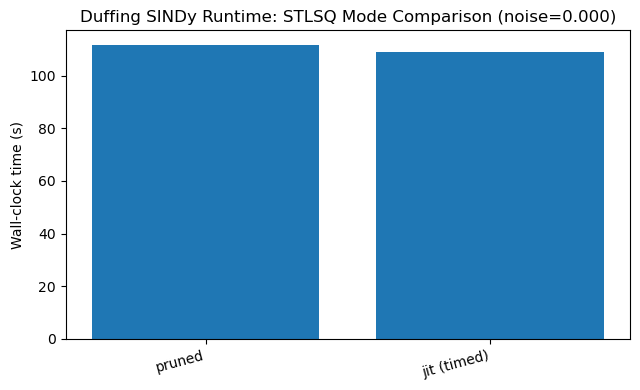

Saved runtime PNG: ../figs\duffing_stlsq_runtime_noise0.000_20251213_145656.png


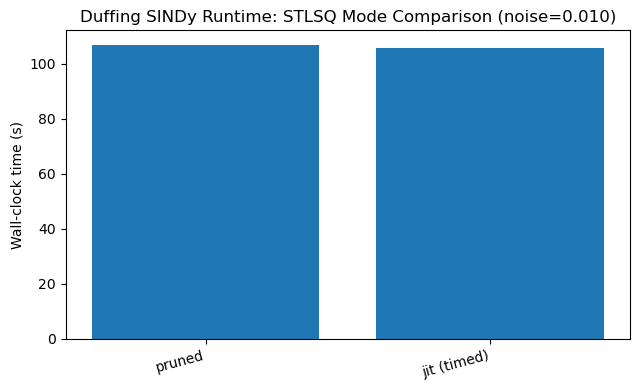

Saved runtime PNG: ../figs\duffing_stlsq_runtime_noise0.010_20251213_145656.png


In [ ]:
import sys, os, time
from copy import deepcopy
from datetime import datetime

sys.path.append(os.path.join("..", "src"))

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

from systems import DuffingDefinition
from sindy_core import SINDyConfig
from run_model import (
    run_sindy_experiment,
    load_experiment,
    make_composite_figure,
    print_equations_from_result,
)

# -------------------------------------------------------
# 0. Common setup
# -------------------------------------------------------
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")

FIG_DIR = "../figs"
os.makedirs(FIG_DIR, exist_ok=True)

OUT_BASE = "../outputs_duffing"
OUT_STLSQ = os.path.join(OUT_BASE, "stlsq_compare")
os.makedirs(OUT_STLSQ, exist_ok=True)

# -------------------------------------------------------
# 1. Duffing parameters 
# -------------------------------------------------------
params = dict(
    alpha=1.0,
    beta=5.0,
    gamma=0.37,
    delta=0.1,
    omega=1.0,
)

duffing = DuffingDefinition(
    parameters=params,
    x0_vector=jnp.array([0.0, 0.0]),
    t0=0.0,
    tf=50.0,
    dt=0.01,
)

# -------------------------------------------------------
# 2. Base SINDy config 
# -------------------------------------------------------
cfg_base = SINDyConfig(
    poly_degree=3,
    include_bias=True,
    threshold=0.05,
    n_iter=10,
    post_tol=1e-3,
    var_names=("x", "v"),
    mode="polynomial_and_fourier",
    k_max=3,
    include_sin=True,
    include_cos=True,
    fourier_prefix="t",
    normalize=True,
    stlsq_mode="pruned",  # will be overwritten per run
)

TRUE = dict(alpha=1.0, beta=5.0, gamma=0.37, delta=0.1, omega=1.0)


# -------------------------------------------------------
# Helpers
# -------------------------------------------------------
def extract_duffing_params(result_dict):
    """
    Extract Duffing parameters from Xi assuming library contains:
      dx/dt = 1*v
      dv/dt = -alpha*x - delta*v - beta*x^3 + gamma*cos(omega t)

    Notes:
      - We pull coefficients by matching feature_names strings.
      - We assume omega=1.0 here; if you ever change omega, adjust matching.
    """
    feature_names = [str(s) for s in result_dict["feature_names"]]
    Xi = np.asarray(result_dict["Xi"])  # (p, 2) for (x', v')

    idx = {name: i for i, name in enumerate(feature_names)}
    # State order: ("x","v") -> col 0 is dx/dt, col 1 is dv/dt
    col_dx, col_dv = 0, 1

    def get_coef(fname, col):
        if fname not in idx:
            return np.nan
        return float(Xi[idx[fname], col])

    # Expected terms
    v_in_dx = get_coef("v", col_dx)

    alpha_hat = -get_coef("x", col_dv)
    delta_hat = -get_coef("v", col_dv)
    beta_hat = -get_coef("x^3", col_dv)

    # forcing: gamma*cos(1t) (per your naming convention)
    gamma_hat = get_coef("cos(1t)", col_dv)

    return dict(
        vcoef_hat=v_in_dx,
        alpha_hat=alpha_hat,
        delta_hat=delta_hat,
        beta_hat=beta_hat,
        gamma_hat=gamma_hat,
    )


def one_run(
    cfg, noise_level=0.0, deriv_key="fd", drop_transient=5.0, outdir=None
):
    assert outdir is not None
    os.makedirs(outdir, exist_ok=True)

    t0 = time.perf_counter()
    path = run_sindy_experiment(
        problem=duffing,
        deriv_key=deriv_key,
        noise_level=noise_level,
        sindy_config=cfg,
        outdir=outdir,
        drop_transient=drop_transient,
    )
    elapsed = time.perf_counter() - t0
    res = load_experiment(path)
    return path, elapsed, res


def compare_two_runs(res_a, res_b):
    Xi_a = np.asarray(res_a["Xi"])
    Xi_b = np.asarray(res_b["Xi"])
    return float(np.max(np.abs(Xi_a - Xi_b))), float(
        np.linalg.norm(Xi_a - Xi_b)
    )


# -------------------------------------------------------
# 3. STLSQ comparison runs (clean + optional noise)
# -------------------------------------------------------
NOISE_LEVELS = (0.0, 0.01)  

rows = []

for noise in NOISE_LEVELS:
    print("\n==============================")
    print(f"Duffing STLSQ compare @ noise={noise:0.3f}")
    print("==============================")

    # PRUNED run
    cfg_pruned = deepcopy(cfg_base)
    cfg_pruned.stlsq_mode = "pruned"
    out_pruned = os.path.join(OUT_STLSQ, f"pruned_{RUN_TAG}_noise{noise:0.3f}")

    pruned_path, pruned_t, res_pruned = one_run(
        cfg_pruned, noise_level=noise, outdir=out_pruned
    )
    print(f"[pruned] {pruned_t:.2f}s | {pruned_path}")
    print_equations_from_result(res_pruned)

    # JIT warmup (compile + run)
    cfg_jit = deepcopy(cfg_base)
    cfg_jit.stlsq_mode = "jit"
    out_jw = os.path.join(OUT_STLSQ, f"jit_warmup_{RUN_TAG}_noise{noise:0.3f}")

    jw_path, jw_t, res_jw = one_run(cfg_jit, noise_level=noise, outdir=out_jw)
    print(f"[jit warmup] {jw_t:.2f}s | {jw_path}")

    # JIT timed 
    out_jt = os.path.join(OUT_STLSQ, f"jit_timed_{RUN_TAG}_noise{noise:0.3f}")
    jt_path, jt_t, res_jt = one_run(cfg_jit, noise_level=noise, outdir=out_jt)
    print(f"[jit timed] {jt_t:.2f}s | {jt_path}")

    # Xi deltas (jit timed vs pruned)
    max_dXi, l2_dXi = compare_two_runs(res_pruned, res_jt)
    print("max |ΔXi| =", max_dXi)
    print("L2  |ΔXi| =", l2_dXi)

    # Extract parameter estimates
    p_pruned = extract_duffing_params(res_pruned)
    p_jit = extract_duffing_params(res_jt)

    # Save composite figs for pruned and jit timed 
    for label, res, fname in [
        (
            "pruned",
            res_pruned,
            f"duffing_pruned_noise{noise:0.3f}_{RUN_TAG}.png",
        ),
        ("jit", res_jt, f"duffing_jit_noise{noise:0.3f}_{RUN_TAG}.png"),
    ]:
        fig, _ = make_composite_figure(
            res, phase_i=0, phase_j=1, labels=["x", "v"]
        )
        fig.savefig(os.path.join(FIG_DIR, fname), dpi=300, bbox_inches="tight")
        plt.close(fig)

    # Build rows
    rows.append(
        dict(
            system="Duffing",
            noise_level=noise,
            mode="pruned",
            runtime_s=pruned_t,
            max_abs_dXi_vs_pruned=0.0,
            l2_dXi_vs_pruned=0.0,
            npz_path=pruned_path,
            **p_pruned,
        )
    )

    rows.append(
        dict(
            system="Duffing",
            noise_level=noise,
            mode="jit (timed)",
            runtime_s=jt_t,
            max_abs_dXi_vs_pruned=max_dXi,
            l2_dXi_vs_pruned=l2_dXi,
            npz_path=jt_path,
            **p_jit,
        )
    )


df = pd.DataFrame(rows)

# Round for display + CSV
df_round = df.copy()
round_cols = {
    "runtime_s": 3,
    "vcoef_hat": 6,
    "alpha_hat": 6,
    "delta_hat": 6,
    "beta_hat": 6,
    "gamma_hat": 6,
    "max_abs_dXi_vs_pruned": 3,
    "l2_dXi_vs_pruned": 3,
}
for c, nd in round_cols.items():
    if c in df_round.columns:
        df_round[c] = df_round[c].astype(float).round(nd)

display(df_round)

# Save summary files
csv_path = os.path.join(FIG_DIR, f"duffing_stlsq_compare_{RUN_TAG}.csv")
npz_path = os.path.join(FIG_DIR, f"duffing_stlsq_compare_{RUN_TAG}.npz")
df_round.to_csv(csv_path, index=False)
np.savez(npz_path, summary=df.to_dict(orient="list"), true_params=TRUE)

print("Saved summary CSV:", csv_path)
print("Saved summary NPZ:", npz_path)

# Simple runtime plot per noise level
for noise in NOISE_LEVELS:
    sub = df[df["noise_level"] == noise]
    plt.figure(figsize=(6.5, 4.0))
    plt.bar(sub["mode"], sub["runtime_s"])
    plt.ylabel("Wall-clock time (s)")
    plt.title(
        f"Duffing SINDy Runtime: STLSQ Mode Comparison (noise={noise:0.3f})"
    )
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    png_path = os.path.join(
        FIG_DIR, f"duffing_stlsq_runtime_noise{noise:0.3f}_{RUN_TAG}.png"
    )
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved runtime PNG:", png_path)